In [65]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (IdentityMessage, LastAggregator,
                                           LastNeighborLoader)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')
path="data/JODIE/"
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0].to(device)

Processing...
Done!


In [13]:
data

TemporalData(dst=[157474], msg=[157474, 172], src=[157474], t=[157474], y=[157474])

In [58]:
print("Are numbers of the dst and src are equal?", np.unique(np.array(data['dst']))==np.unique(np.array(data['src'])))

Are numbers of the dst and src are equal? False


<ipython-input-58-8d972ed036a9>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("Are numbers of the dst and src are equal?", np.unique(np.array(data['dst']))==np.unique(np.array(data['src'])))


In [59]:
data["t"].shape

torch.Size([157474])

In [62]:
data["t"].dtype 

torch.int64

In [63]:
data["dst"].dtype 

torch.int64

In [64]:
data["msg"].dtype 

torch.float32

In [19]:
len(data["y"][data["y"]==0])

157257

In [20]:
len(data["y"][data["y"]==1])

217

In [53]:
data['t']

tensor([      0,      36,      77,  ..., 2678293, 2678333, 2678373])

In [61]:
data['msg'].shape

torch.Size([157474, 172])

In [22]:
min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())

In [25]:
train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

In [26]:
data.num_nodes

9227

In [27]:
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

In [29]:
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

In [30]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

In [31]:
memory_dim = time_dim = embedding_dim = 100

In [32]:
memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

In [33]:
gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

In [34]:
link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

In [35]:
optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

In [36]:
# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


In [37]:
def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_data.seq_batches(batch_size=200):
        optimizer.zero_grad()

        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

        # Sample negative destination nodes.
        neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                dtype=torch.long, device=device)

        n_id = torch.cat([src, pos_dst, neg_dst]).unique()
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
        neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events

In [38]:
@torch.no_grad()
def test(inference_data):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs = [], []
    for batch in inference_data.seq_batches(batch_size=200):
        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

        neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                dtype=torch.long, device=device)

        n_id = torch.cat([src, pos_dst, neg_dst]).unique()
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
        neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)

    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

In [39]:
train_loss=[]
val_acc=[]
test_acc=[]
for epoch in range(1, 51):
    loss = train()
    train_loss.append(loss)
    print(f'  Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc = test(val_data)
    val_acc.append(val_ap)
    test_ap, test_auc = test(test_data)
    test_acc.append(test_ap)
    print(f' Val AP: {val_ap:.4f},  Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

  Epoch: 01, Loss: 1.0665
 Val AP: 0.8686,  Val AUC: 0.8825
Test AP: 0.8425, Test AUC: 0.8578
  Epoch: 02, Loss: 0.8419
 Val AP: 0.9133,  Val AUC: 0.9167
Test AP: 0.9010, Test AUC: 0.9065
  Epoch: 03, Loss: 0.7168
 Val AP: 0.9386,  Val AUC: 0.9329
Test AP: 0.9306, Test AUC: 0.9253
  Epoch: 04, Loss: 0.6695
 Val AP: 0.9421,  Val AUC: 0.9355
Test AP: 0.9367, Test AUC: 0.9299
  Epoch: 05, Loss: 0.6466
 Val AP: 0.9491,  Val AUC: 0.9431
Test AP: 0.9392, Test AUC: 0.9327
  Epoch: 06, Loss: 0.6214
 Val AP: 0.9492,  Val AUC: 0.9436
Test AP: 0.9421, Test AUC: 0.9362
  Epoch: 07, Loss: 0.5940
 Val AP: 0.9533,  Val AUC: 0.9465
Test AP: 0.9446, Test AUC: 0.9378
  Epoch: 08, Loss: 0.5803
 Val AP: 0.9555,  Val AUC: 0.9497
Test AP: 0.9466, Test AUC: 0.9406
  Epoch: 09, Loss: 0.5620
 Val AP: 0.9572,  Val AUC: 0.9511
Test AP: 0.9449, Test AUC: 0.9384
  Epoch: 10, Loss: 0.5494
 Val AP: 0.9598,  Val AUC: 0.9533
Test AP: 0.9508, Test AUC: 0.9445
  Epoch: 11, Loss: 0.5358
 Val AP: 0.9616,  Val AUC: 0.9557


In [40]:
data['dst']

tensor([8227, 8228, 8228,  ..., 8722, 9147, 8722])

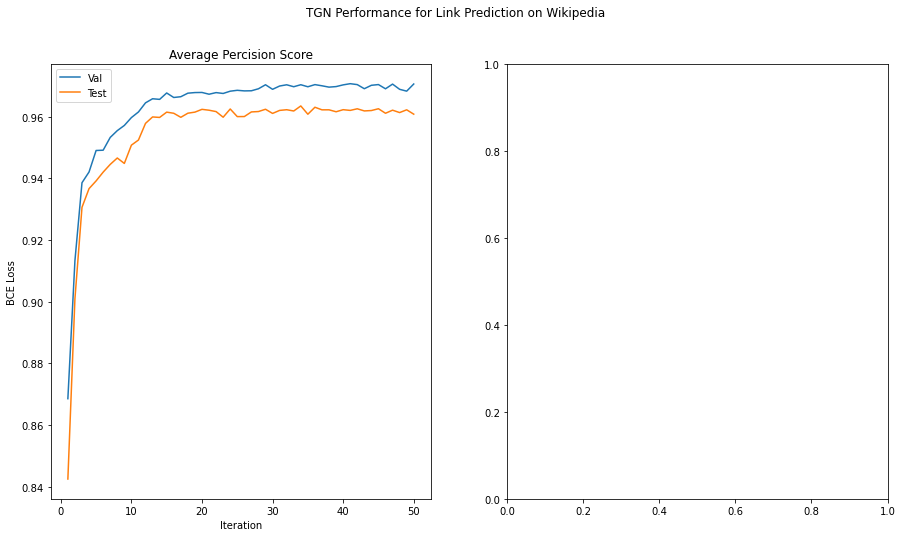

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('TGN Performance for Link Prediction on Wikipedia')
#ax1.plot(range(1,51),train_l,label='Train')
ax1.plot(range(1,51),val_acc,label='Val')
ax1.plot(range(1,51),test_acc,label='Test')
#ax1.title('Binary CrossEntropy Loss')
ax1.set_title('Average Percision Score')
ax1.set(xlabel='Iteration', ylabel='BCE Loss')
ax1.legend()